# Depth-band plots

Loads depth-frequency-time data and then plots integrated depth-band power for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
for i in range(2):
    %matplotlib notebook

In [2]:
# import data

adcp = 'Shoulder'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2018

if adcp == 'Shoulder':
    adcp2 = 'Axis55'
    ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp2}_1min_{year}_0.nc')
    n_seg = ds_in.n_seg
    if n_seg > 1:
        ds = [ds_in]
        for i in range(n_seg):
            if i > 0:
                ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp2}_1min_{year}_{i}.nc')
                ds.append(ds_temp)
    elif n_seg == 1:
        ds = [ds_in]

else:
    ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')
    n_seg = ds_in.n_seg
    if n_seg > 1:
        ds = [ds_in]
        for i in range(n_seg):
            if i > 0:
                ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
                ds.append(ds_temp)
    elif n_seg == 1:
        ds = [ds_in]

In [3]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                     # input end date in YYYY,MM,DD
depth = ds[0].depth.values
d = len(depth)

## Subdiurnal

In [ ]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_s)    # input array to process 

f_name = 'Subdiurnal'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.16e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [7.00e-5,1.20e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,9.00e-6]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

### Depth-band PSD spectra

In [ ]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_d[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_d[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

In [ ]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)  

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save PSD data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            u_WKB=(['depth','spect_s'], u_WKB[i]),        # low-pass data
            v_WKB=(['depth','spect_s'], v_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB PSD {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_psd_{f_name}_{adcp}_{t_stamp}_{i}.nc')

### Depth-band rotary spectra

In [ ]:
# integrate over band for each time step

cw_power, ccw_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    cw_depth_power_temp,ccw_depth_power_temp = [],[]
    for j in range(d):
        cw_time_power_temp,ccw_time_power_temp = [],[]
        for k in range(t):
            cw_PSD_temp = ds[i].cw_d[j,low_f_idx:up_f_idx+1,k]
            cw_power_temp = np.trapz(y=cw_PSD_temp,x=f_band)
            cw_time_power_temp.append(cw_power_temp)
            ccw_PSD_temp = ds[i].ccw_d[j,low_f_idx:up_f_idx+1,k]
            ccw_power_temp = np.trapz(y=ccw_PSD_temp,x=f_band)
            ccw_time_power_temp.append(ccw_power_temp)
        cw_depth_power_temp.append(cw_time_power_temp)
        ccw_depth_power_temp.append(ccw_time_power_temp)
    cw_np = np.asarray(cw_depth_power_temp)
    ccw_np = np.asarray(ccw_depth_power_temp)
    cw_power.append(cw_np)            # n_seg, [depth, time]
    ccw_power.append(ccw_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]
for i in range(n_seg):
    cw_WKB_temp,ccw_WKB_temp = [],[]
    for j in range(d):
        cw_WKB_temp.append(cw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        ccw_WKB_temp.append(ccw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    cw_WKB.append(cw_WKB_temp)
    ccw_WKB.append(ccw_WKB_temp)

In [ ]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3

fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# depth average for each time at upper (lower) depths and save .nc

if f_name == 'Inertial':
    # select depths
    if adcp == 'Slope':
        d_up_idx = 4     # 35
        d_low_idx = 20   # 155
    elif adcp == 'Axis75':
        d_up_idx = 58
        d_low_idx = 79
    elif adcp == 'Axis55':
        d_up_idx = 40
        d_low_idx = 48

    # save to .nc file for wind

    for i in range(n_seg):
        ds_out = xr.Dataset( 
            data_vars=dict(
                cw=(['depth','time'], cw_WKB[i]),        # integrated near-inertial power [(m/s)^2]
            ),
            coords=dict(
                depth=depth,               # m
                time=ds[i].spect_s.values,                     # np.datetime64    
            ),
            attrs=dict(
                description=f'WKB-scaled and integrated near-inertial power for wind comparison, {adcp}, {t_stamp}. Segment {i} of {n_seg}.',
                units=['(m/s)^2, m, numpy.datetime64'],
                n_seg=n_seg,
                d_up_idx = d_up_idx,
                d_low_idx = d_low_idx,
                depth_up=depth[d_up_idx],
                depth_low=depth[d_low_idx],
            ),
        ) 
        ds_out.to_netcdf(f'../Data/wind/cw_inertial_{adcp}_{t_stamp}_{i}.nc')

In [ ]:
# save rotary data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            cw_WKB=(['depth','spect_s'], cw_WKB[i]),        # low-pass data
            ccw_WKB=(['depth','spect_s'], ccw_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB rotary {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_rot_{f_name}_{adcp}_{t_stamp}_{i}.nc')

## Diurnal

In [ ]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_s)    # input array to process 

f_name = 'Diurnal'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.16e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [7.00e-5,1.20e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,1.00e-5]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

### Depth-band PSD spectra

In [ ]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_d[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_d[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

In [ ]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)  

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save PSD data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            u_WKB=(['depth','spect_s'], u_WKB[i]),        # low-pass data
            v_WKB=(['depth','spect_s'], v_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB PSD {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_psd_{f_name}_{adcp}_{t_stamp}_{i}.nc')

### Depth-band rotary spectra

In [ ]:
# integrate over band for each time step

cw_power, ccw_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    cw_depth_power_temp,ccw_depth_power_temp = [],[]
    for j in range(d):
        cw_time_power_temp,ccw_time_power_temp = [],[]
        for k in range(t):
            cw_PSD_temp = ds[i].cw_d[j,low_f_idx:up_f_idx+1,k]
            cw_power_temp = np.trapz(y=cw_PSD_temp,x=f_band)
            cw_time_power_temp.append(cw_power_temp)
            ccw_PSD_temp = ds[i].ccw_d[j,low_f_idx:up_f_idx+1,k]
            ccw_power_temp = np.trapz(y=ccw_PSD_temp,x=f_band)
            ccw_time_power_temp.append(ccw_power_temp)
        cw_depth_power_temp.append(cw_time_power_temp)
        ccw_depth_power_temp.append(ccw_time_power_temp)
    cw_np = np.asarray(cw_depth_power_temp)
    ccw_np = np.asarray(ccw_depth_power_temp)
    cw_power.append(cw_np)            # n_seg, [depth, time]
    ccw_power.append(ccw_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]
for i in range(n_seg):
    cw_WKB_temp,ccw_WKB_temp = [],[]
    for j in range(d):
        cw_WKB_temp.append(cw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        ccw_WKB_temp.append(ccw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    cw_WKB.append(cw_WKB_temp)
    ccw_WKB.append(ccw_WKB_temp)

In [ ]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3

fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# depth average for each time at upper (lower) depths and save .nc

if f_name == 'Inertial':
    # select depths
    if adcp == 'Slope':
        d_up_idx = 4     # 35
        d_low_idx = 20   # 155
    elif adcp == 'Axis75':
        d_up_idx = 58
        d_low_idx = 79
    elif adcp == 'Axis55':
        d_up_idx = 40
        d_low_idx = 48

    # save to .nc file for wind

    for i in range(n_seg):
        ds_out = xr.Dataset( 
            data_vars=dict(
                cw=(['depth','time'], cw_WKB[i]),        # integrated near-inertial power [(m/s)^2]
            ),
            coords=dict(
                depth=depth,               # m
                time=ds[i].spect_s.values,                     # np.datetime64    
            ),
            attrs=dict(
                description=f'WKB-scaled and integrated near-inertial power for wind comparison, {adcp}, {t_stamp}. Segment {i} of {n_seg}.',
                units=['(m/s)^2, m, numpy.datetime64'],
                n_seg=n_seg,
                d_up_idx = d_up_idx,
                d_low_idx = d_low_idx,
                depth_up=depth[d_up_idx],
                depth_low=depth[d_low_idx],
            ),
        ) 
        ds_out.to_netcdf(f'../Data/wind/cw_inertial_{adcp}_{t_stamp}_{i}.nc')

In [ ]:
# save rotary data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            cw_WKB=(['depth','spect_s'], cw_WKB[i]),        # low-pass data
            ccw_WKB=(['depth','spect_s'], ccw_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB rotary {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_rot_{f_name}_{adcp}_{t_stamp}_{i}.nc')

## Inertial

In [ ]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_s)    # input array to process 

f_name = 'Inertial'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.16e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [7.00e-5,1.20e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,1.00e-5]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

### Depth-band PSD spectra

In [ ]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_d[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_d[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

In [ ]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)  

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save PSD data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            u_WKB=(['depth','spect_s'], u_WKB[i]),        # low-pass data
            v_WKB=(['depth','spect_s'], v_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB PSD {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_psd_{f_name}_{adcp}_{t_stamp}_{i}.nc')

### Depth-band rotary spectra

In [ ]:
# integrate over band for each time step

cw_power, ccw_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    cw_depth_power_temp,ccw_depth_power_temp = [],[]
    for j in range(d):
        cw_time_power_temp,ccw_time_power_temp = [],[]
        for k in range(t):
            cw_PSD_temp = ds[i].cw_d[j,low_f_idx:up_f_idx+1,k]
            cw_power_temp = np.trapz(y=cw_PSD_temp,x=f_band)
            cw_time_power_temp.append(cw_power_temp)
            ccw_PSD_temp = ds[i].ccw_d[j,low_f_idx:up_f_idx+1,k]
            ccw_power_temp = np.trapz(y=ccw_PSD_temp,x=f_band)
            ccw_time_power_temp.append(ccw_power_temp)
        cw_depth_power_temp.append(cw_time_power_temp)
        ccw_depth_power_temp.append(ccw_time_power_temp)
    cw_np = np.asarray(cw_depth_power_temp)
    ccw_np = np.asarray(ccw_depth_power_temp)
    cw_power.append(cw_np)            # n_seg, [depth, time]
    ccw_power.append(ccw_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]
for i in range(n_seg):
    cw_WKB_temp,ccw_WKB_temp = [],[]
    for j in range(d):
        cw_WKB_temp.append(cw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        ccw_WKB_temp.append(ccw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    cw_WKB.append(cw_WKB_temp)
    ccw_WKB.append(ccw_WKB_temp)

In [ ]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(8,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.93, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.02, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.965, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.02, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.125,0.885, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3

fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

# draw vertical lines
plt.annotate("", xy=(210, 330), xycoords='figure points', xytext=(115, 375), textcoords='figure points',\
              arrowprops=dict(arrowstyle="-", edgecolor = "white", linewidth=3, alpha=1, connectionstyle="arc3,rad=0."))
plt.annotate("", xy=(208, 332), xycoords='figure points', xytext=(208, 230), textcoords='figure points',\
              arrowprops=dict(arrowstyle="-", edgecolor = "white", linewidth=3, alpha=1, connectionstyle="arc3,rad=0."))
fig.text(0.2,0.755,r'$\sim$8 days',fontsize=14,color='white')

date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.set_xlim(np.datetime64('2014-09-01'),np.datetime64('2014-10-01'))
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# depth average for each time at upper (lower) depths and save .nc

if f_name == 'Inertial':
    # select depths
    if adcp == 'Slope':
        d_up_idx = 4     # 35
        d_low_idx = -1   # lower
    elif adcp == 'Axis75':
        d_up_idx = 58
        d_low_idx = 79
    elif adcp == 'Axis55':
        d_up_idx = 40
        d_low_idx = 48

    # save to .nc file for wind

    for i in range(n_seg):
        ds_out = xr.Dataset( 
            data_vars=dict(
                cw=(['depth','time'], cw_WKB[i]),        # integrated near-inertial power [(m/s)^2]
            ),
            coords=dict(
                depth=depth,               # m
                time=ds[i].spect_s.values,                     # np.datetime64    
            ),
            attrs=dict(
                description=f'WKB-scaled and integrated near-inertial power for wind comparison, {adcp}, {t_stamp}. Segment {i} of {n_seg}.',
                units=['(m/s)^2, m, numpy.datetime64'],
                n_seg=n_seg,
                d_up_idx = d_up_idx,
                d_low_idx = d_low_idx,
                depth_up=depth[d_up_idx],
                depth_low=depth[d_low_idx],
            ),
        ) 
        ds_out.to_netcdf(f'../Data/wind/cw_inertial_{adcp}_{t_stamp}_{i}.nc')

In [ ]:
# save rotary data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            cw_WKB=(['depth','spect_s'], cw_WKB[i]),        # low-pass data
            ccw_WKB=(['depth','spect_s'], ccw_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB rotary {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_rot_{f_name}_{adcp}_{t_stamp}_{i}.nc')

## Semidiurnal

In [ ]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_s)    # input array to process 

f_name = 'Semidiurnal'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.16e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [7.00e-5,1.20e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,1.00e-5]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

### Depth-band PSD spectra

In [ ]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_d[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_d[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

In [ ]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)  

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save PSD data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            u_WKB=(['depth','spect_s'], u_WKB[i]),        # low-pass data
            v_WKB=(['depth','spect_s'], v_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB PSD {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_psd_{f_name}_{adcp}_{t_stamp}_{i}.nc')

### Depth-band rotary spectra

In [ ]:
# integrate over band for each time step

cw_power, ccw_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    cw_depth_power_temp,ccw_depth_power_temp = [],[]
    for j in range(d):
        cw_time_power_temp,ccw_time_power_temp = [],[]
        for k in range(t):
            cw_PSD_temp = ds[i].cw_d[j,low_f_idx:up_f_idx+1,k]
            cw_power_temp = np.trapz(y=cw_PSD_temp,x=f_band)
            cw_time_power_temp.append(cw_power_temp)
            ccw_PSD_temp = ds[i].ccw_d[j,low_f_idx:up_f_idx+1,k]
            ccw_power_temp = np.trapz(y=ccw_PSD_temp,x=f_band)
            ccw_time_power_temp.append(ccw_power_temp)
        cw_depth_power_temp.append(cw_time_power_temp)
        ccw_depth_power_temp.append(ccw_time_power_temp)
    cw_np = np.asarray(cw_depth_power_temp)
    ccw_np = np.asarray(ccw_depth_power_temp)
    cw_power.append(cw_np)            # n_seg, [depth, time]
    ccw_power.append(ccw_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]
for i in range(n_seg):
    cw_WKB_temp,ccw_WKB_temp = [],[]
    for j in range(d):
        cw_WKB_temp.append(cw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        ccw_WKB_temp.append(ccw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    cw_WKB.append(cw_WKB_temp)
    ccw_WKB.append(ccw_WKB_temp)

In [ ]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3

fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save rotary data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            cw_WKB=(['depth','spect_s'], cw_WKB[i]),        # low-pass data
            ccw_WKB=(['depth','spect_s'], ccw_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB rotary {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_rot_{f_name}_{adcp}_{t_stamp}_{i}.nc')

## Continuum

In [ ]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_s)    # input array to process 

f_name = 'Continuum'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.16e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [7.00e-5,1.20e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,1.00e-5]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

### Depth-band PSD spectra

In [ ]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_d[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_d[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

In [ ]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)  

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save PSD data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            u_WKB=(['depth','spect_s'], u_WKB[i]),        # low-pass data
            v_WKB=(['depth','spect_s'], v_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB PSD {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_psd_{f_name}_{adcp}_{t_stamp}_{i}.nc')

### Depth-band rotary spectra

In [ ]:
# integrate over band for each time step

cw_power, ccw_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    cw_depth_power_temp,ccw_depth_power_temp = [],[]
    for j in range(d):
        cw_time_power_temp,ccw_time_power_temp = [],[]
        for k in range(t):
            cw_PSD_temp = ds[i].cw_d[j,low_f_idx:up_f_idx+1,k]
            cw_power_temp = np.trapz(y=cw_PSD_temp,x=f_band)
            cw_time_power_temp.append(cw_power_temp)
            ccw_PSD_temp = ds[i].ccw_d[j,low_f_idx:up_f_idx+1,k]
            ccw_power_temp = np.trapz(y=ccw_PSD_temp,x=f_band)
            ccw_time_power_temp.append(ccw_power_temp)
        cw_depth_power_temp.append(cw_time_power_temp)
        ccw_depth_power_temp.append(ccw_time_power_temp)
    cw_np = np.asarray(cw_depth_power_temp)
    ccw_np = np.asarray(ccw_depth_power_temp)
    cw_power.append(cw_np)            # n_seg, [depth, time]
    ccw_power.append(ccw_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]
for i in range(n_seg):
    cw_WKB_temp,ccw_WKB_temp = [],[]
    for j in range(d):
        cw_WKB_temp.append(cw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        ccw_WKB_temp.append(ccw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    cw_WKB.append(cw_WKB_temp)
    ccw_WKB.append(ccw_WKB_temp)

In [ ]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3

fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save rotary data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            cw_WKB=(['depth','spect_s'], cw_WKB[i]),        # low-pass data
            ccw_WKB=(['depth','spect_s'], ccw_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB rotary {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/depthband_rot_{f_name}_{adcp}_{t_stamp}_{i}.nc')

## Shoulder

In [ ]:
# select frequency band

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest value

f_array = np.asarray(ds[0].specf_s)    # input array to process 

f_name = 'Shoulder'          # Subdiurnal, Diurnal, Inertial, Semidiurnal, Continuum
if f_name == 'Diurnal':
    f_freq = 1.16e-5         # desired frequency constituent
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx 
elif f_name == 'Inertial':
    f_freq = 1.73e-5
    f_idx = find_nearest(f_array, f_freq)                 # index of desired frequency
    up_f_idx = f_idx + 1
    low_f_idx = f_idx - 1
elif f_name == 'Semidiurnal':
    f_freq = 2.24e-5
    f_idx = find_nearest(f_array, f_freq)
    up_f_idx = f_idx + 1
    low_f_idx = f_idx
elif f_name == 'Continuum':
    f_freq = [7.00e-5,1.20e-4]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Subdiurnal':
    f_freq = [2.00e-6,1.00e-5]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])
elif f_name == 'Shoulder':
    f_freq = [1.00e-4,1.00e-3]
    low_f_idx = find_nearest(f_array, f_freq[0])
    up_f_idx = find_nearest(f_array, f_freq[1])    
    
print("Desired frequency band:",f_name,'at', f_freq, "Hz")
print("---")
print("Index at upper freq cutoff:", up_f_idx)
print("Value at upper freq cutoff:", f_array[up_f_idx], "Hz" )
print('---')
print("Index at lower freq cutoff:", low_f_idx)
print("Value at lower freq cutoff:", f_array[low_f_idx], "Hz" )

f_band = f_array[low_f_idx:up_f_idx+1]              # remove unwanted frequencies
fup_stamp = f_band[-1]                              # freq stamps for use in output
flow_stamp = f_band[0]

print('---')
print("Length of new freq array: ", len(f_band))   # new freq interval
print(f'Upper limit at',fup_stamp,'Hz')            # freq upper limit
print(f'Lower limit at',flow_stamp,'Hz')           # freq lower limit

### Depth-band PSD spectra

In [ ]:
# integrate over band for each time step

u_power, v_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    u_depth_power_temp,v_depth_power_temp = [],[]
    for j in range(d):
        u_time_power_temp,v_time_power_temp = [],[]
        for k in range(t):
            u_PSD_temp = ds[i].Sxxu_d[j,low_f_idx:up_f_idx+1,k]
            u_power_temp = np.trapz(y=u_PSD_temp,x=f_band)
            u_time_power_temp.append(u_power_temp)
            v_PSD_temp = ds[i].Sxxv_d[j,low_f_idx:up_f_idx+1,k]
            v_power_temp = np.trapz(y=v_PSD_temp,x=f_band)
            v_time_power_temp.append(v_power_temp)
        u_depth_power_temp.append(u_time_power_temp)
        v_depth_power_temp.append(v_time_power_temp)
    u_np = np.asarray(u_depth_power_temp)
    v_np = np.asarray(v_depth_power_temp)
    u_power.append(u_np)            # n_seg, [depth, time]
    v_power.append(v_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(u_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        v_WKB_temp.append(v_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    u_WKB.append(u_WKB_temp)
    v_WKB.append(v_WKB_temp)

In [ ]:
# plot PSD frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

if f_name == 'Shoulder':
    fig.text(0.5, 0.94, f'{f_name} - {adcp2} - {t_stamp}', ha='center', fontsize=14)
else:
    fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)  
elif f_name == 'Shoulder':
    if adcp2 == 'Slope':
        vmin = 8e-5
        vmax = 5e-4
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-slope', ha='center', fontsize=14)
    elif adcp2 == 'Axis75' or adcp2 == 'Axis55':
        vmin = 1e-4
        vmax = 8e-4
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.479, 'Along-canyon', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, u_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, v_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

if adcp == 'Shoulder':
    plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp2}_{t_stamp}.pdf',format='pdf')
else:
    plt.savefig(fname=f'./plots/depthband_plots/{f_name}_psd_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save PSD data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            u_WKB=(['depth','spect_s'], u_WKB[i]),        # low-pass data
            v_WKB=(['depth','spect_s'], v_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB PSD {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    if f_name == 'Shoulder':
        ds_out.to_netcdf(f'../Data/interannual/depthband_psd_{f_name}_{adcp2}_{t_stamp}_{i}.nc')
    else:
        ds_out.to_netcdf(f'../Data/interannual/depthband_psd_{f_name}_{adcp}_{t_stamp}_{i}.nc')

### Depth-band rotary spectra

In [ ]:
# integrate over band for each time step

cw_power, ccw_power = [],[]

for i in range(n_seg):
    t = len(ds[i].spect_s)
    cw_depth_power_temp,ccw_depth_power_temp = [],[]
    for j in range(d):
        cw_time_power_temp,ccw_time_power_temp = [],[]
        for k in range(t):
            cw_PSD_temp = ds[i].cw_d[j,low_f_idx:up_f_idx+1,k]
            cw_power_temp = np.trapz(y=cw_PSD_temp,x=f_band)
            cw_time_power_temp.append(cw_power_temp)
            ccw_PSD_temp = ds[i].ccw_d[j,low_f_idx:up_f_idx+1,k]
            ccw_power_temp = np.trapz(y=ccw_PSD_temp,x=f_band)
            ccw_time_power_temp.append(ccw_power_temp)
        cw_depth_power_temp.append(cw_time_power_temp)
        ccw_depth_power_temp.append(ccw_time_power_temp)
    cw_np = np.asarray(cw_depth_power_temp)
    ccw_np = np.asarray(ccw_depth_power_temp)
    cw_power.append(cw_np)            # n_seg, [depth, time]
    ccw_power.append(ccw_np)            # n_seg, [depth, time]

In [ ]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]
for i in range(n_seg):
    cw_WKB_temp,ccw_WKB_temp = [],[]
    for j in range(d):
        cw_WKB_temp.append(cw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
        ccw_WKB_temp.append(ccw_power[i][j] / ds[0].WKB_scale[j].values)          # list[depth][frequency]
    cw_WKB.append(cw_WKB_temp)
    ccw_WKB.append(ccw_WKB_temp)

In [ ]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

if f_name == 'Shoulder':
    fig.text(0.5, 0.94, f'{f_name} - {adcp2} - {t_stamp}', ha='center', fontsize=14)
else:
    fig.text(0.5, 0.94, f'{f_name} - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled',fontsize=14)

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
elif f_name == 'Shoulder':
    if adcp2 == 'Slope':
        vmin = 8e-5
        vmax = 5e-4
    elif adcp2 == 'Axis75' or adcp2 == 'Axis55':
        vmin = 1e-4
        vmax = 8e-4
        
fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, -depth, cw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ds[i].spect_s, -depth, ccw_WKB[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

if adcp == 'Shoulder':
    plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp2}_{t_stamp}.pdf',format='pdf')
else:
    plt.savefig(fname=f'./plots/depthband_plots/{f_name}_rot_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# save rotary data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            cw_WKB=(['depth','spect_s'], cw_WKB[i]),        # low-pass data
            ccw_WKB=(['depth','spect_s'], ccw_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            spect_s=ds[i].spect_s.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Depth-band WKB rotary {f_name} data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    if f_name == 'Shoulder':
        ds_out.to_netcdf(f'../Data/interannual/depthband_rot_{f_name}_{adcp2}_{t_stamp}_{i}.nc')
    else:
        ds_out.to_netcdf(f'../Data/interannual/depthband_rot_{f_name}_{adcp}_{t_stamp}_{i}.nc')

## Inter-annual comparisons

In [7]:
site = 'Axis'     # Slope or Axis

### Sub-diurnal

In [ ]:
# import PSD data and plot

f_name = 'Subdiurnal'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if site == 'Axis':
        vmin = 1e-4
        vmax = 4e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 1e-4
        vmax = 4e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_psd_{site}.pdf',format='pdf')

In [ ]:
# import rotary data and plot

f_name = 'Subdiurnal'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if site == 'Axis':
        vmin = 1e-4
        vmax = 4e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 1e-4
        vmax = 4e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14) 

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_rot_{site}.pdf',format='pdf')

### Diurnal

In [ ]:
# import PSD data and plot

f_name = 'Diurnal'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if site == 'Axis':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_psd_{site}.pdf',format='pdf')

In [ ]:
# import rotary data and plot

f_name = 'Diurnal'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if site == 'Axis':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_rot_{site}.pdf',format='pdf')

### Inertial

In [ ]:
# import PSD data and plot

f_name = 'Inertial'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if site == 'Axis':
        vmin = 6e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 6e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_psd_{site}.pdf',format='pdf')

In [ ]:
# import rotary data and plot

f_name = 'Inertial'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if site == 'Axis':
        vmin = 6e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 6e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_rot_{site}.pdf',format='pdf')

### Semidiurnal

In [ ]:
# import PSD data and plot

f_name = 'Semidiurnal'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if site == 'Axis':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_psd_{site}.pdf',format='pdf')

In [ ]:
# import rotary data and plot

f_name = 'Semidiurnal'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if site == 'Axis':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_rot_{site}.pdf',format='pdf')

### Continuum

In [ ]:
# import PSD data and plot

f_name = 'Continuum'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if site == 'Axis':
        vmin = 0.9e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_psd_{site}.pdf',format='pdf')

In [ ]:
# import rotary data and plot

f_name = 'Continuum'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if site == 'Axis':
        vmin = 0.9e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)  

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-650, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-650, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-650, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-650, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_rot_{site}.pdf',format='pdf')

### Shoulder

<IPython.core.display.Javascript object>


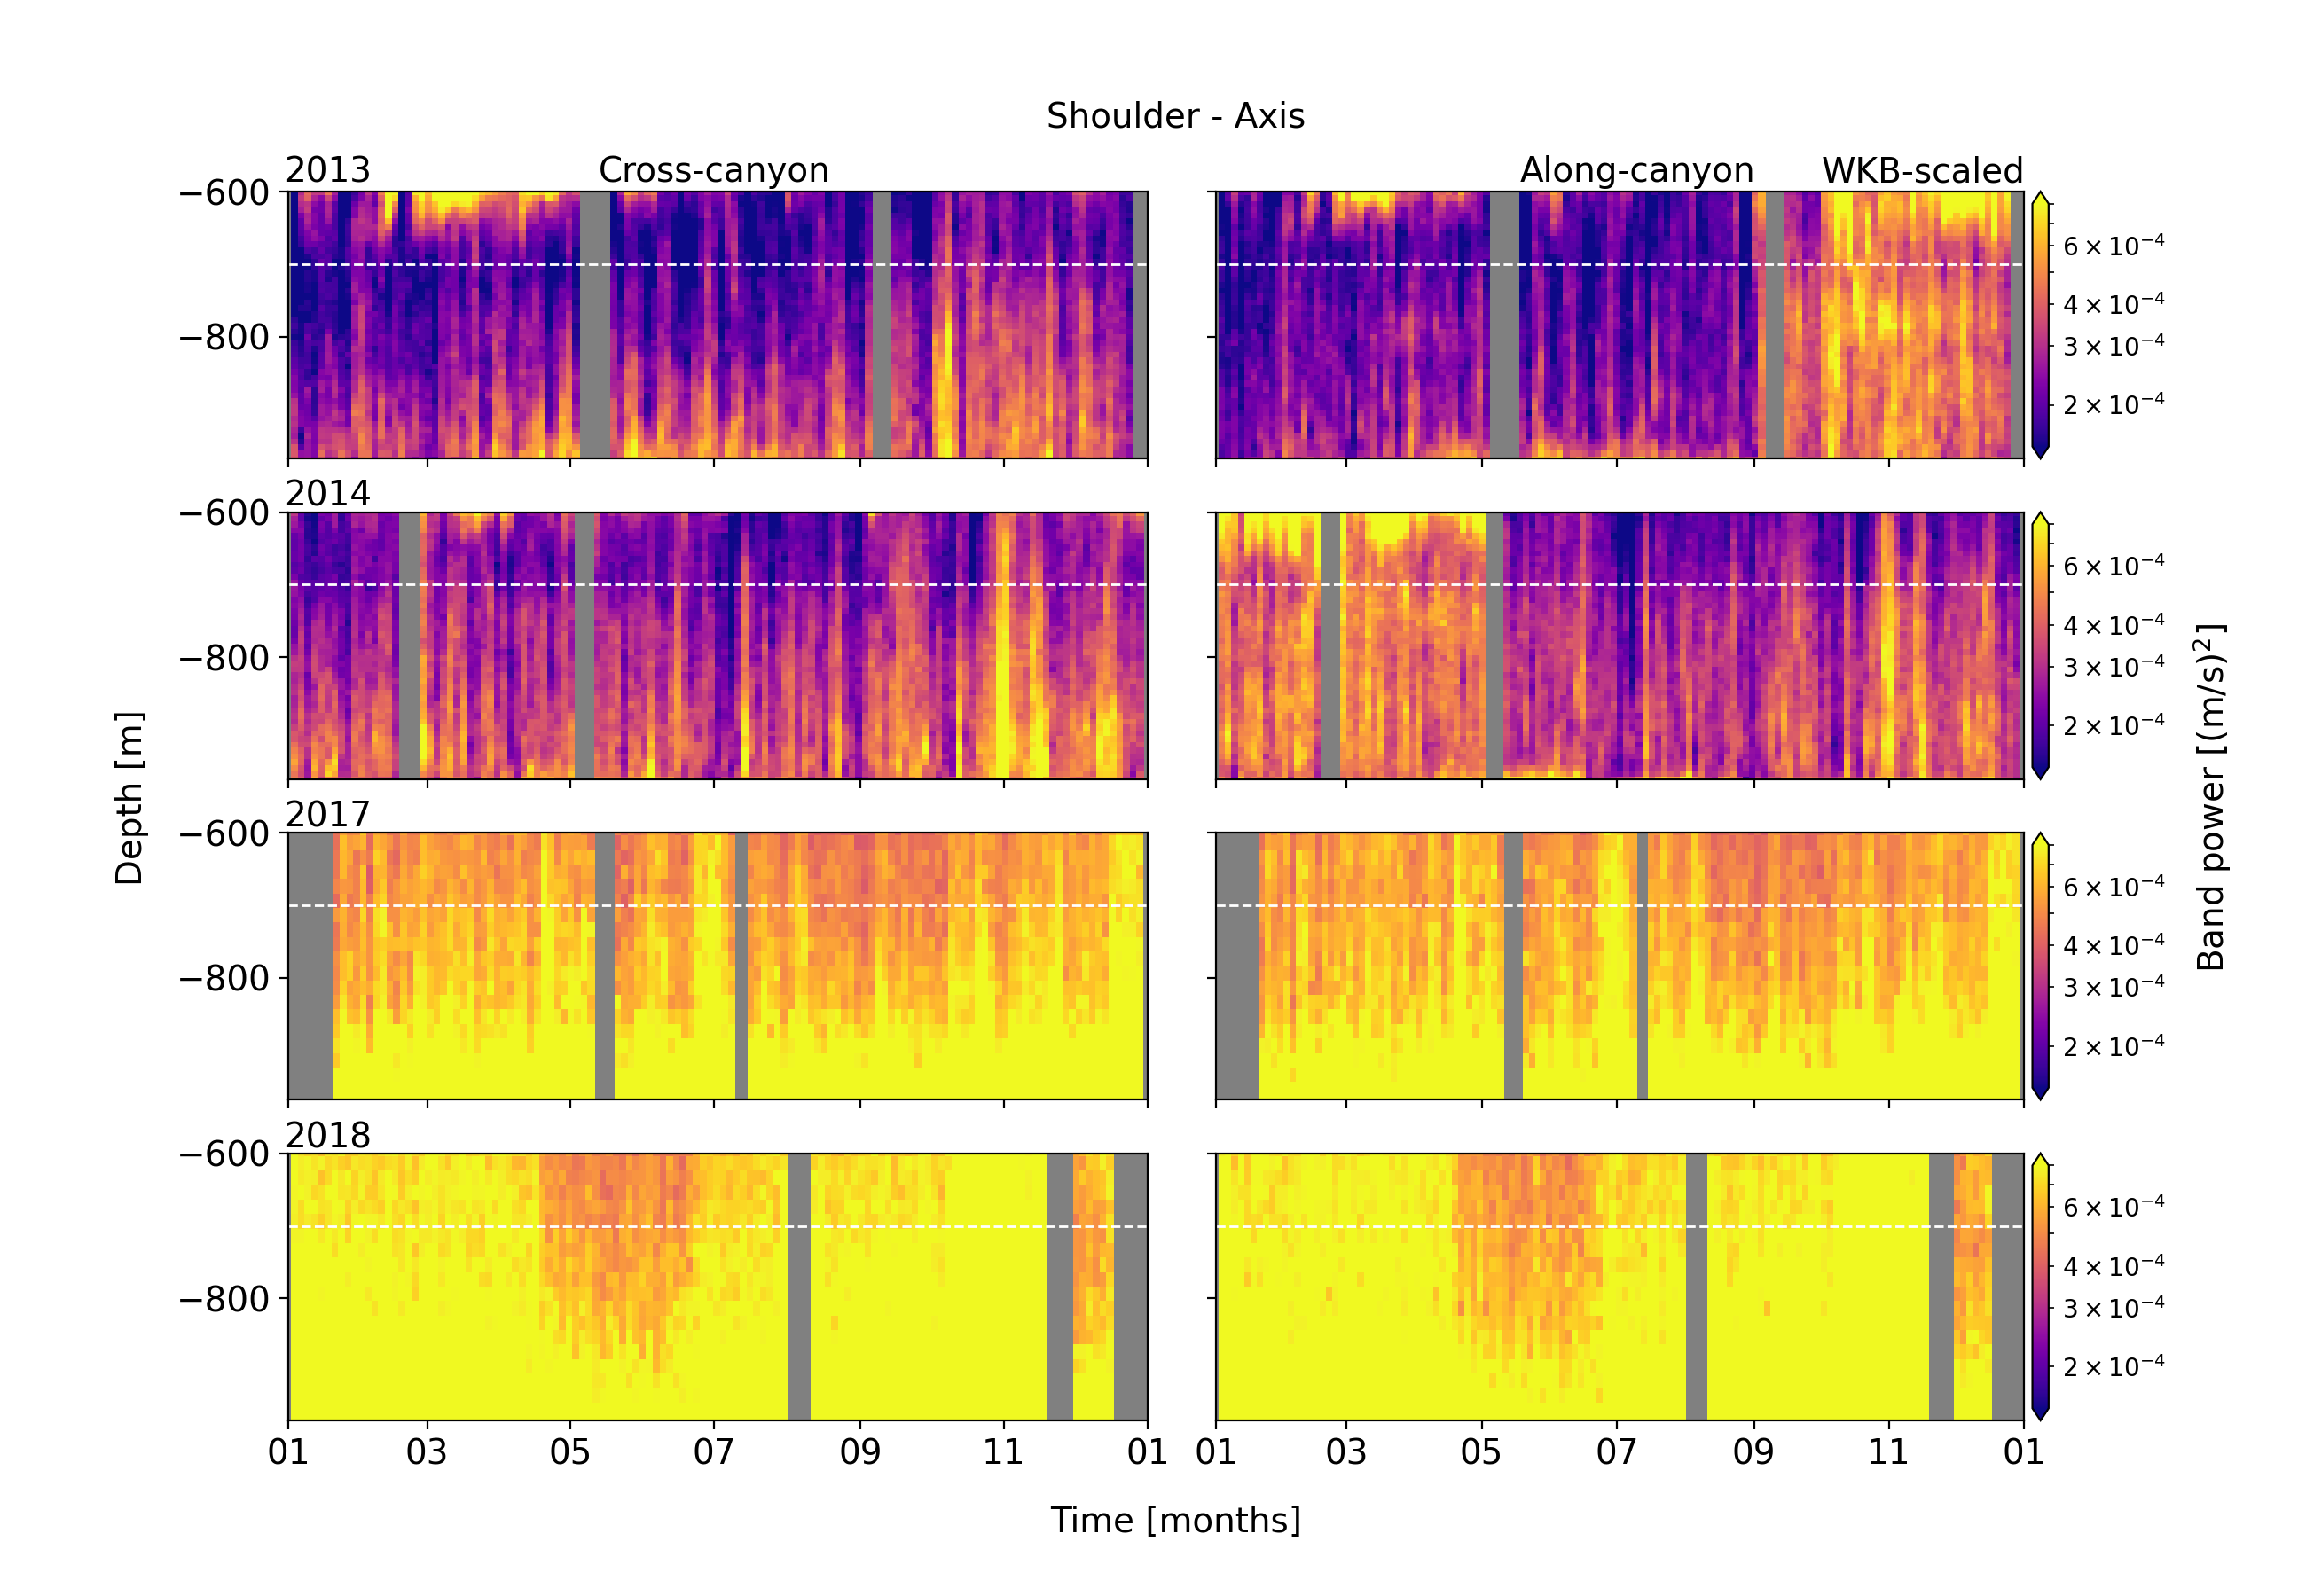

In [8]:
# import PSD data and plot

f_name = 'Shoulder'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_0.nc'))
    #ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_2.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if site == 'Axis':
        vmin = 0.9e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)  
elif f_name == 'Shoulder':  
    if site == 'Axis':
        vmin = 1.5e-4
        vmax = 8e-4
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 8e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].u_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].v_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-700, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-700, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-700, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-700, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
if f_name == 'Shoulder' and site == 'Slope':
    ax7.set_ylim(-ds_2013[0].depth[0],0)
elif f_name == 'Shoulder' and site == 'Axis':
    ax7.set_ylim(-ds_2013[0].depth[0],-600)
else:
    ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_psd_{site}.pdf',format='pdf')

<IPython.core.display.Javascript object>


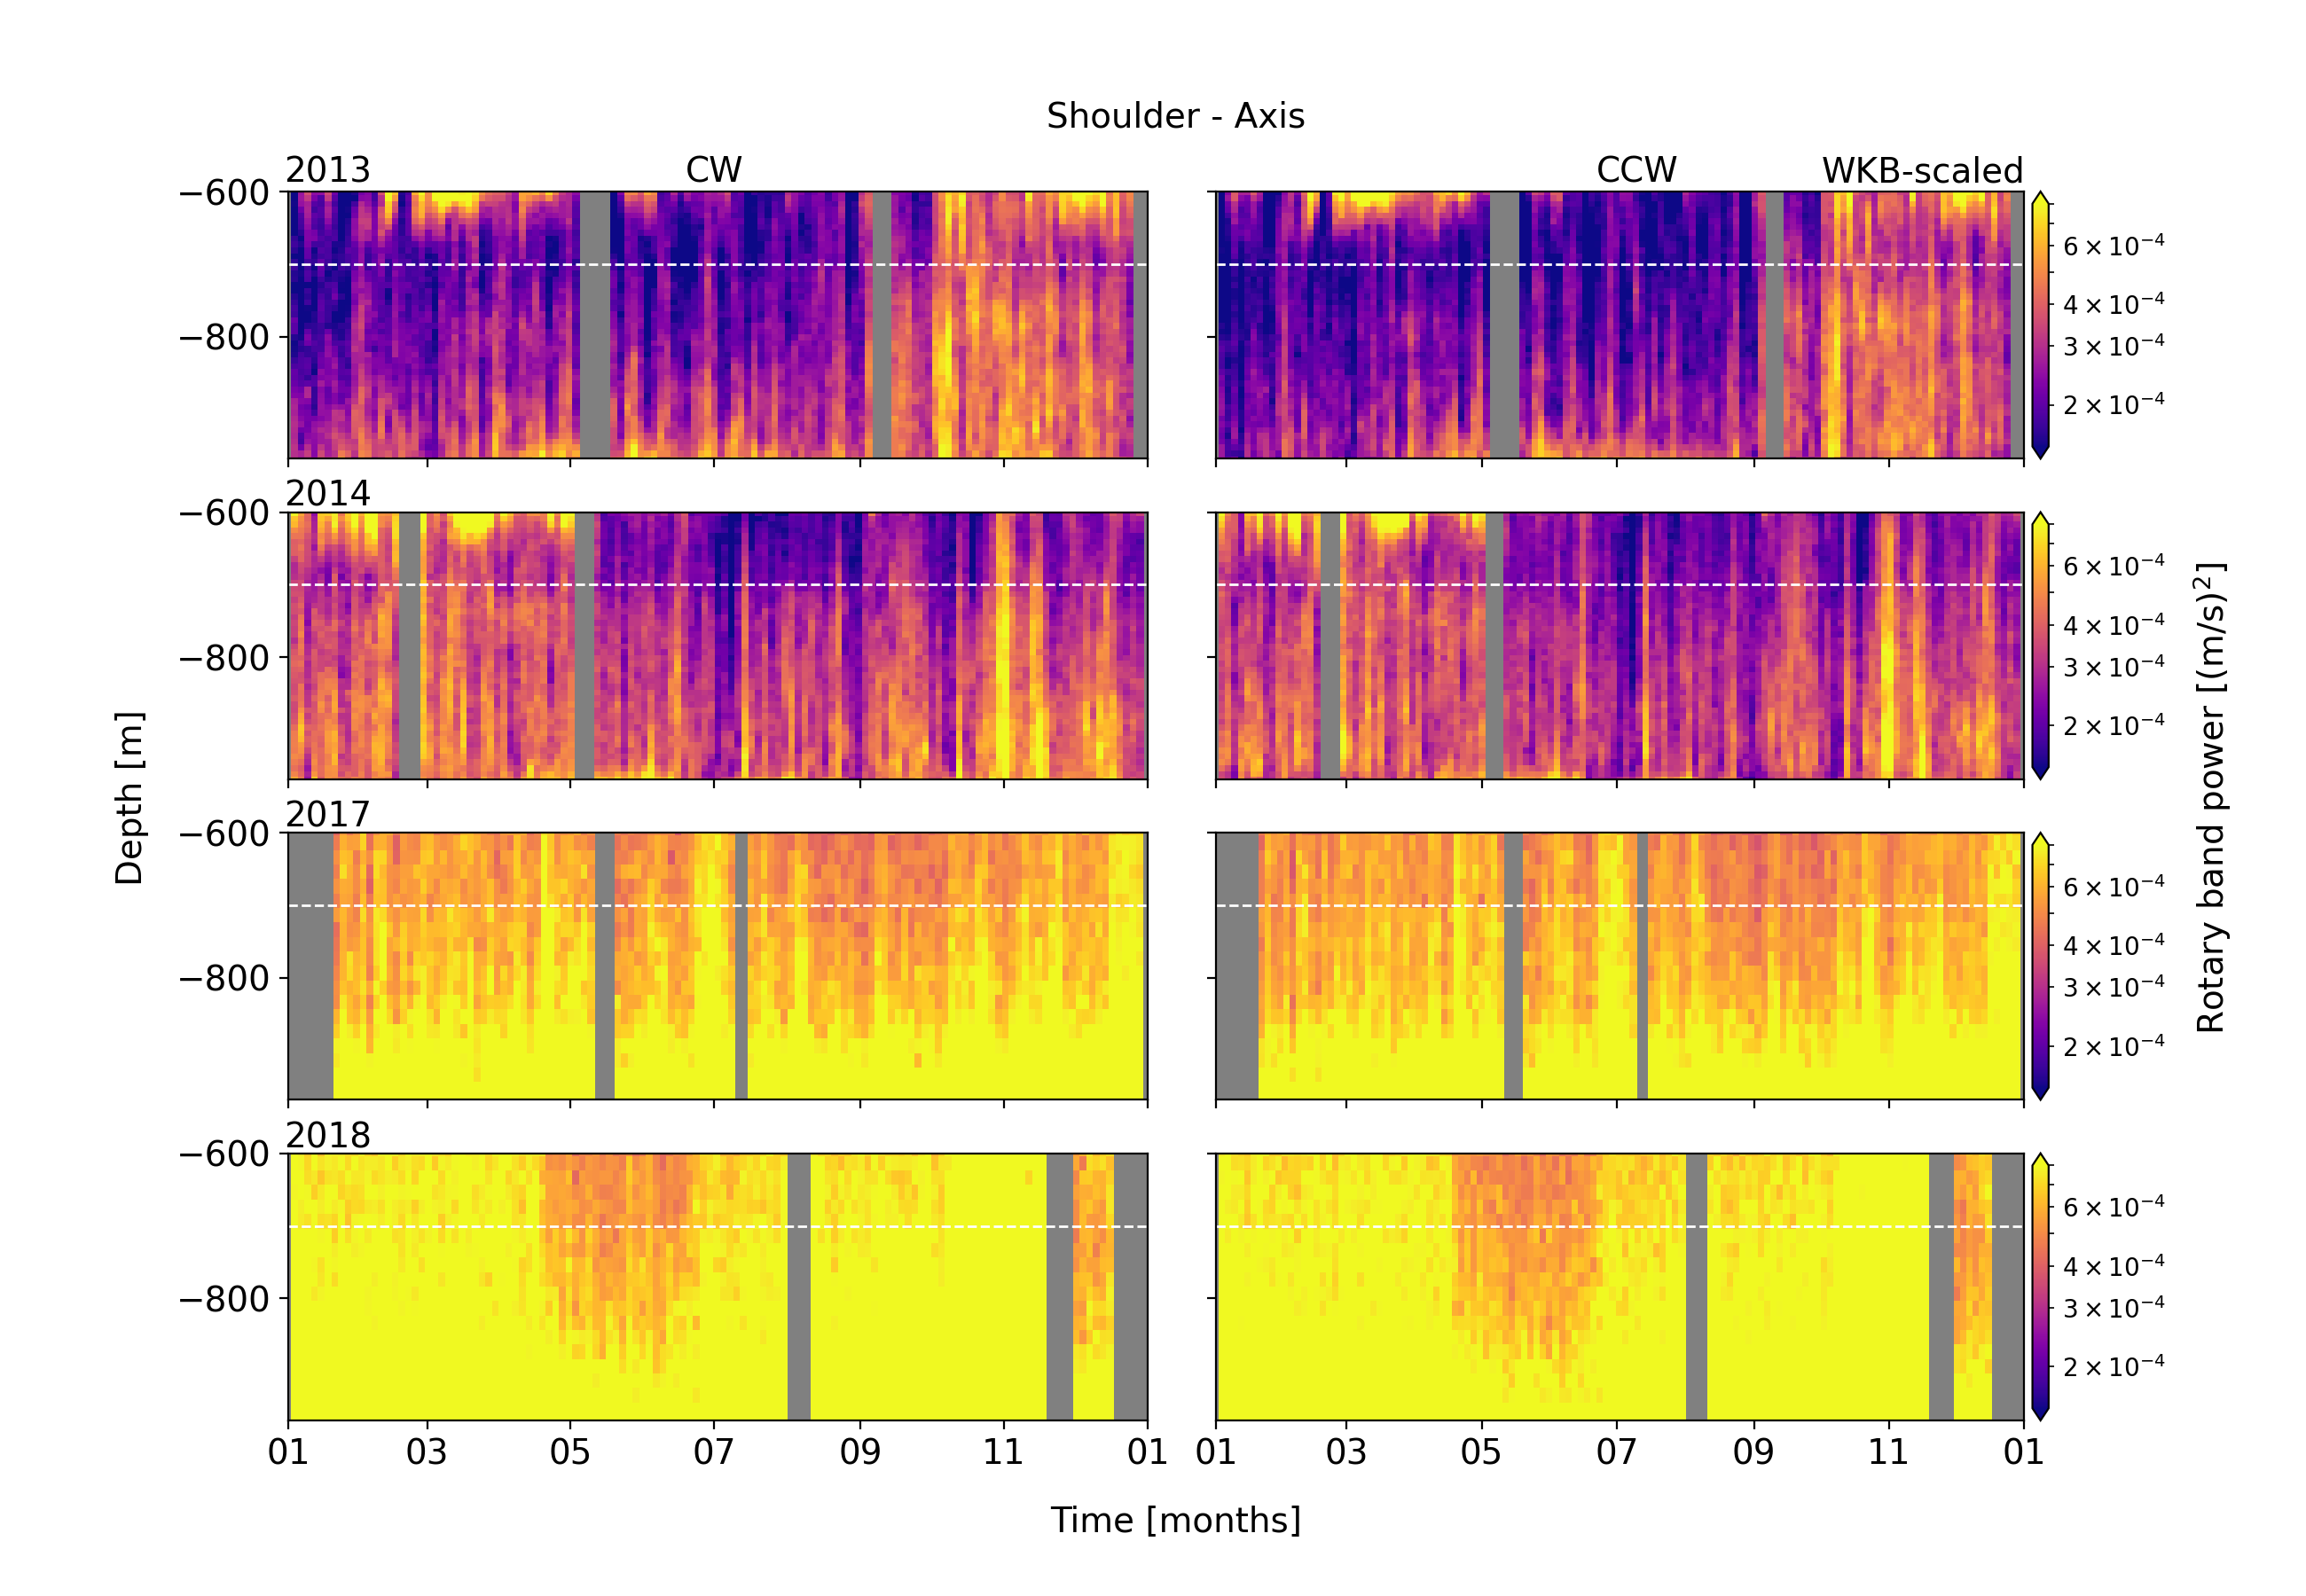

In [9]:
# import rotary data and plot

f_name = 'Shoulder'     # do not change

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_0.nc'))
    #ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_4.nc'))
    #ds_2018.append(xr.open_dataset(f'../Data/interannual/depthband_psd_{f_name}_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

# plot PSD frequency band power versus depth

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
#fig.subplots_adjust(hspace = 0.15)

fig.text(0.51, 0.92, f'{f_name} - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Rotary band power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.79,0.886, 'WKB-scaled',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if f_name == 'Diurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Inertial':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Semidiurnal':  
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 5e-5
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Continuum':  
    if site == 'Axis':
        vmin = 0.9e-4
        vmax = 4e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 5e-5
        vmax = 3e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
elif f_name == 'Subdiurnal':  
    if adcp == 'Axis75':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif adcp == 'Axis55':
        vmin = 1e-4
        vmax = 5e-3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)  
elif f_name == 'Shoulder':  
    if site == 'Axis':
        vmin = 1.5e-4
        vmax = 8e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 8e-5
        vmax = 5e-4
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
        
date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018] 
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im1 = ax1.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax0.xaxis.set_major_formatter(date_form)
            ax1.xaxis.set_major_formatter(date_form)
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im3 = ax3.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax2.xaxis.set_major_formatter(date_form)
            ax3.xaxis.set_major_formatter(date_form)
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im5 = ax5.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax4.xaxis.set_major_formatter(date_form)
            ax5.xaxis.set_major_formatter(date_form)
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].spect_s, -i[j].depth, i[j].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
            im7 = ax7.pcolormesh(i[j].spect_s, -i[j].depth, i[j].ccw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto') 
            ax6.xaxis.set_major_formatter(date_form)
            ax7.xaxis.set_major_formatter(date_form)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

start_dates = [np.datetime64('2013-01-01'),np.datetime64('2014-01-01'),np.datetime64('2017-01-01'),np.datetime64('2018-01-01')]
end_dates = [np.datetime64('2014-01-01'),np.datetime64('2015-01-01'),np.datetime64('2018-01-01'),np.datetime64('2019-01-01')]
for i in [ax0,ax1]:
    i.set_xlim(start_dates[0],end_dates[0])
    i.hlines(y=-700, xmin=start_dates[0],xmax=end_dates[0], linewidth=1, color='white', ls='--')
for i in [ax2,ax3]:
    i.set_xlim(start_dates[1],end_dates[1])
    i.hlines(y=-700, xmin=start_dates[1],xmax=end_dates[1], linewidth=1, color='white', ls='--')
for i in [ax4,ax5]:
    i.set_xlim(start_dates[2],end_dates[2])
    i.hlines(y=-700, xmin=start_dates[2],xmax=end_dates[2], linewidth=1, color='white', ls='--')
for i in [ax6,ax7]:
    i.set_xlim(start_dates[3],end_dates[3])
    i.hlines(y=-700, xmin=start_dates[3],xmax=end_dates[3], linewidth=1, color='white', ls='--')

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
if f_name == 'Shoulder' and site == 'Slope':
    ax7.set_ylim(-ds_2013[0].depth[0],0)
elif f_name == 'Shoulder' and site == 'Axis':
    ax7.set_ylim(-ds_2013[0].depth[0],-600)
else:
    ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthband_{f_name}_rot_{site}.pdf',format='pdf')